<a href="https://colab.research.google.com/github/Kostia9/Data-Analysis-2025/blob/main/Lab4/Lab4_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Генерація зображень за допомогою дифузійної моделі

**Датасет**: https://www.kaggle.com/datasets/splcher/animefacedataset

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import math
import copy
from tqdm import tqdm
from IPython.display import clear_output
from torch.amp import GradScaler, autocast

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

In [2]:
# --- 1. ЗАВАНТАЖЕННЯ ДАНИХ (KAGGLEHUB) ---
import kagglehub
path = kagglehub.dataset_download("splcher/animefacedataset")
print("Path to dataset:", path)

Using Colab cache for faster access to the 'animefacedataset' dataset.
Path to dataset: /kaggle/input/animefacedataset


In [3]:
# --- 2. ПІДГОТОВКА ДАНИХ  ---
# Створюємо список шляхів до зображень
image_paths = []
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            full_path = os.path.join(dirname, filename)
            image_paths.append(full_path)

print(f"Found {len(image_paths)} images.")

Found 63565 images.


In [4]:
class ImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        path = self.image_paths[idx]
        img = Image.open(path).convert('RGB')
        img = self.transform(img)
        return img

In [5]:
# Налаштування параметрів
IMG_SIZE = 96
BATCH_SIZE = 128
TIMESTEPS = 1000
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Трансформації (нормалізація до [-1, 1] для дифузії)
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # [0, 1] -> [-1, 1]
])

# Створення датасету та лоадера
train_data = ImageDataset(image_paths, transform)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)


This dataset contains 63,632 anime faces

In [6]:
def show_tensor_image(image):
    # 1. Обробка батчу (якщо прийшло [1, 3, 64, 64], беремо [3, 64, 64])
    if len(image.shape) == 4:
        image = image[0]
    # 2. Перенесення на CPU та відключення градієнтів
    image = image.detach().cpu()
    # 3. Денормалізація: [-1, 1] -> [0, 1]
    image = (image + 1) / 2
    # 4. Захист від виходу за межі
    image = image.clamp(0, 1)
    # 5. Перестановка каналів: PyTorch [C, H, W] -> Matplotlib [H, W, C]
    image = image.permute(1, 2, 0)
    # 6. Малюємо
    plt.imshow(image.numpy())
    plt.axis('off')

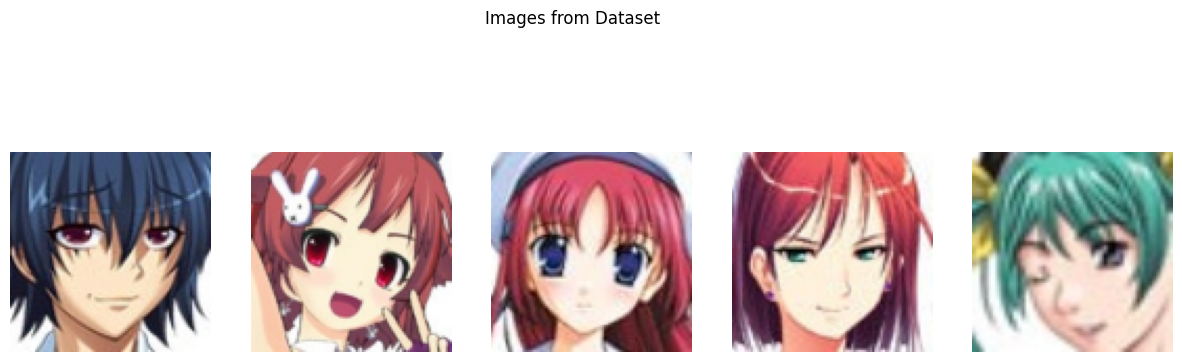

In [7]:
# --- Visualize Images from Dataset ---
data_iter = iter(train_loader)
images = next(data_iter)

plt.figure(figsize=(15, 5))
plt.suptitle("Images from Dataset")
for i in range(5):
    plt.subplot(1, 5, i+1)
    show_tensor_image(images[i])
    plt.axis('off')
plt.show()

In [8]:
# --- 3. МОДЕЛЬ U-NET ---

# Модель має знати, на якому кроці зашумлення t вона знаходиться
# Використовуються синусоїдальні ембедінги, щоб передати цю інформацію в мережу
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim, n_groups=8):
        super().__init__()

        self.time_mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_emb_dim, out_channels),
        )

        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.GroupNorm(n_groups, out_channels),
            nn.SiLU(),
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.GroupNorm(n_groups, out_channels),
            nn.SiLU(),
        )

        # Якщо вхідні канали != вихідним, потрібна проекція для додавання (residual)
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, 1)
        else:
            self.shortcut = nn.Identity()

    def forward(self, x, t):
        h = self.block1(x)
        # Додаємо час (time embedding)
        time_emb = self.time_mlp(t)
        time_emb = time_emb[(..., ) + (None, ) * 2] # Розширюємо розмірність
        h = h + time_emb

        h = self.block2(h)
        return h + self.shortcut(x) # Residual connection

class SelfAttention(nn.Module):
    def __init__(self, channels):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        B, C, H, W = x.shape
        # Перетворюємо (Batch, Channels, Height, Width) -> (Batch, Seq_Len, Channels)
        x = x.view(B, C, H * W).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        # Повертаємо назад у (Batch, Channels, Height, Width)
        return attention_value.swapaxes(2, 1).view(B, C, H, W)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, time_emb_dim=256):
        super().__init__()

        # Time Embedding
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim),
        )

        self.conv0 = nn.Conv2d(in_channels, 64, 3, padding=1)

        # Downsample
        self.down1 = ResidualBlock(64, 128, time_emb_dim)
        self.down2 = ResidualBlock(128, 256, time_emb_dim)
        self.sa1 = SelfAttention(256)
        self.down3 = ResidualBlock(256, 512, time_emb_dim)
        self.sa2 = SelfAttention(512)

        # Bottleneck
        self.mid1 = ResidualBlock(512, 512, time_emb_dim)
        self.sa3 = SelfAttention(512)
        self.mid2 = ResidualBlock(512, 512, time_emb_dim)

        # Upsample
        self.up1 = nn.ConvTranspose2d(512, 256, 4, 2, 1)
        self.up_block1 = ResidualBlock(768, 256, time_emb_dim)
        self.sa4 = SelfAttention(256)

        self.up2 = nn.ConvTranspose2d(256, 128, 4, 2, 1)
        self.up_block2 = ResidualBlock(384, 128, time_emb_dim)

        self.up3 = nn.ConvTranspose2d(128, 64, 4, 2, 1)
        self.up_block3 = ResidualBlock(192, 64, time_emb_dim)

        self.output = nn.Conv2d(64, out_channels, 1)

    def forward(self, x, timestep):
        t = self.time_mlp(timestep)
        x0 = self.conv0(x) # Input Size

        # --- Downsample ---
        x1 = self.down1(x0, t)
        x1_pool = F.max_pool2d(x1, 2) # -> Size / 2

        x2 = self.down2(x1_pool, t)
        x2 = self.sa1(x2)
        x2_pool = F.max_pool2d(x2, 2) # -> Size / 4

        x3 = self.down3(x2_pool, t)
        x3 = self.sa2(x3)
        x3_pool = F.max_pool2d(x3, 2) # -> Size / 8

        # --- Bottleneck ---
        mid = self.mid1(x3_pool, t)
        mid = self.sa3(mid)
        mid = self.mid2(mid, t) # Size / 8 (No change)

        # --- Upsample ---
        # Size / 8 -> Size / 4
        up_1 = self.up1(mid)
        up_1 = torch.cat([up_1, x3], dim=1)
        up_1 = self.up_block1(up_1, t)
        up_1 = self.sa4(up_1)

        # Size / 4 -> Size / 2
        up_2 = self.up2(up_1)
        up_2 = torch.cat([up_2, x2], dim=1)
        up_2 = self.up_block2(up_2, t)

        # Size / 2 -> Input Size
        up_3 = self.up3(up_2)
        up_3 = torch.cat([up_3, x1], dim=1)
        up_3 = self.up_block3(up_3, t)

        return self.output(up_3)

**EMA** зберігає "тіньову" копію моделі, ваги якої оновлюються дуже повільно і плавно.
    
    Переваги:
    1. Краща якість генерації: Картинки виходять більш гладкими, з меншою кількістю шуму та артефактів.
    2. Стабільність: EMA-модель менш чутлива до різких стрибків Loss-функції.
    3. Це стандарт для Diffusion Models: Майже всі state-of-the-art моделі (Stable Diffusion, DALL-E)
       використовують EMA для генерації.

In [9]:
class EMA(nn.Module):
    def __init__(self, model, beta=0.9999, update_after_step=100, update_every=10):
        super().__init__()
        self.beta = beta
        self.update_after_step = update_after_step # Кількість кроків розігріву (warmup)
        self.update_every = update_every           # Оновлюємо не кожен крок, щоб економити ресурси

        # Лічильник кроків (зберігається в state_dict)
        self.register_buffer('step', torch.tensor(0))

        # Створюємо тіньову копію моделі
        self.ema_model = copy.deepcopy(model).eval().requires_grad_(False)

        # Визначаємо, які параметри вимагають градієнтів (щоб не копіювати зайве)
        self.parameter_names = {name for name, param in self.ema_model.named_parameters() if param.dtype in [torch.float32, torch.float16]}

    def update(self, model):
        self.step += 1
        step = self.step.item()

        # Оптимізація: оновлюємо тільки кожен N-й крок
        if step % self.update_every != 0:
            return

        # На старті (warmup) просто копіюємо параметри, щоб не тягнути шум ініціалізації
        if step < self.update_after_step:
            self.reset_parameters(model)
            return

        # Доступ до оригінальної моделі
        source_model = model._orig_mod if hasattr(model, '_orig_mod') else model

        with torch.no_grad():
            # 1. Оновлення ваг (Parameters) через lerp
            # lerp: new = old + weight * (current - old) -> еквівалент згладжування
            for (name, current_params), (_, ema_params) in zip(source_model.named_parameters(), self.ema_model.named_parameters()):
                if name in self.parameter_names:
                    ema_params.lerp_(current_params, 1.0 - self.beta)

            # 2. Оновлення буферів (BatchNorm stats) - пряме копіювання
            for current_buffer, ema_buffer in zip(source_model.buffers(), self.ema_model.buffers()):
                ema_buffer.copy_(current_buffer)

    def reset_parameters(self, model):
        source_model = model._orig_mod if hasattr(model, '_orig_mod') else model
        self.ema_model.load_state_dict(source_model.state_dict())

    # Дозволяє викликати ema(x) як звичайну модель
    def forward(self, *args, **kwargs):
        return self.ema_model(*args, **kwargs)

In [10]:
# --- 4. МАТЕМАТИКА ДИФУЗІЇ ---
TIMESTEPS = 1000

betas = torch.linspace(0.0001, 0.02, TIMESTEPS).to(DEVICE)

alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

def forward_diffusion_sample(x_0, t, device=DEVICE):
    """Додає шум до картинки"""
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = sqrt_alphas_cumprod[t].view(-1, 1, 1, 1)
    sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod[t].view(-1, 1, 1, 1)
    return sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise, noise

In [11]:
@torch.no_grad()
def sample_image(model, img_size, batch_size=5):
    # Починаємо з чистого шуму
    img = torch.randn((batch_size, 3, img_size, img_size), device=DEVICE)
    print("Sampling...")

    for i in reversed(range(0, TIMESTEPS)):
        t = torch.full((batch_size,), i, device=DEVICE, dtype=torch.long)
        predicted_noise = model(img, t)

        alpha = alphas[i]
        alpha_hat = alphas_cumprod[i]
        beta = betas[i]

        if i > 0:
            noise = torch.randn_like(img)
        else:
            noise = torch.zeros_like(img)

        img = (1 / torch.sqrt(alpha)) * (img - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise

    img = torch.clamp(img, -1.0, 1.0)
    return img

Starting training...


Epoch 5/30: 100%|██████████| 496/496 [03:26<00:00,  2.40it/s, loss=0.0166]


Sampling...


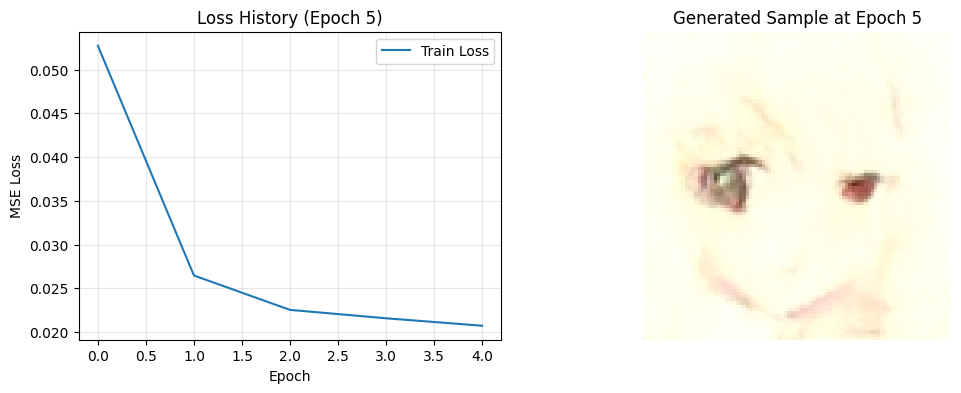

Epoch 10/30: 100%|██████████| 496/496 [03:27<00:00,  2.39it/s, loss=0.0168]


Sampling...


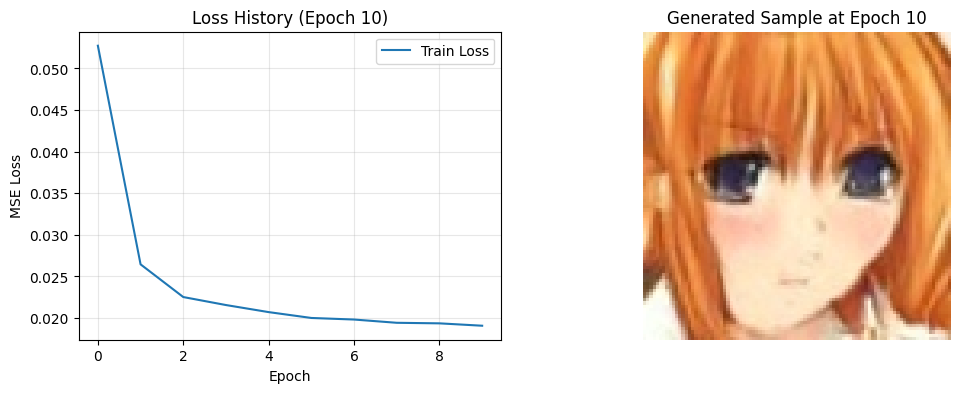

Epoch 15/30: 100%|██████████| 496/496 [03:27<00:00,  2.39it/s, loss=0.0159]


Sampling...


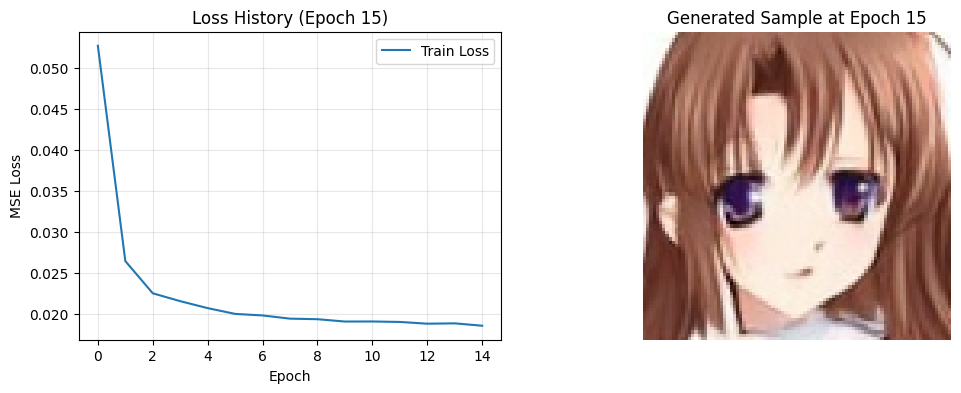

Epoch 20/30: 100%|██████████| 496/496 [03:27<00:00,  2.39it/s, loss=0.0175]


Sampling...


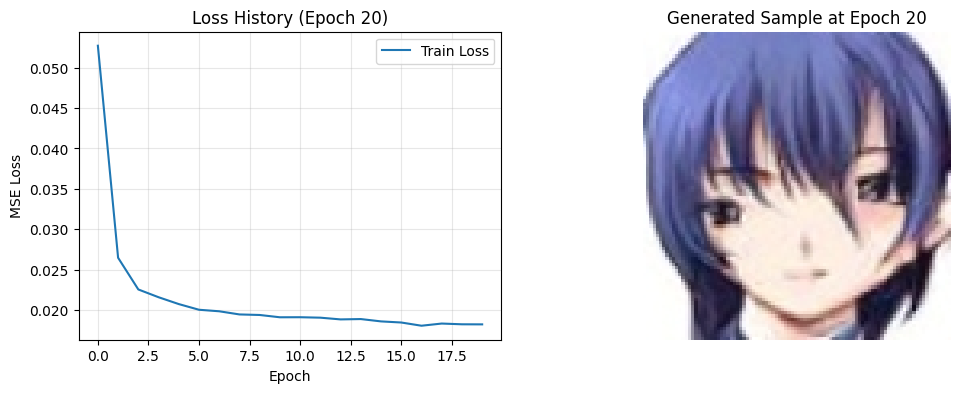

Epoch 25/30: 100%|██████████| 496/496 [03:27<00:00,  2.39it/s, loss=0.0143]


Sampling...


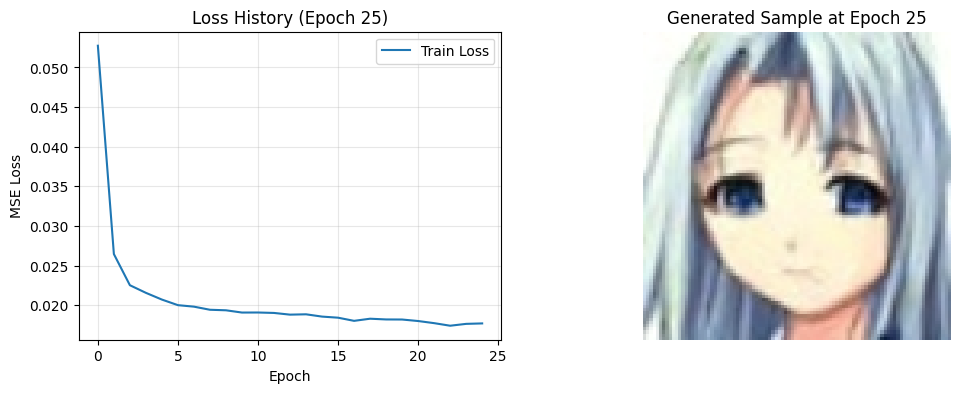

Epoch 30/30: 100%|██████████| 496/496 [03:27<00:00,  2.39it/s, loss=0.0222]


Sampling...


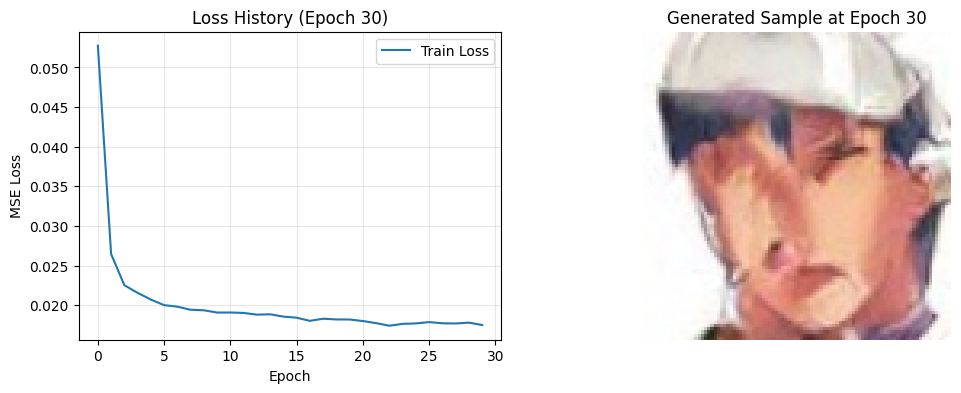

In [13]:
# --- 5. ТРЕНУВАННЯ ---
model = UNet().to(DEVICE)

# Initialize ema
ema = EMA(model, beta=0.995, update_after_step=2000, update_every=10).to(DEVICE)

loss_fn = nn.MSELoss()
model = torch.compile(model)
EPOCHS = 30
print("Starting training...")

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
scaler = GradScaler('cuda')

loss_history = []
for epoch in range(1, EPOCHS+1):
    epoch_loss = 0
    model.train()
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}")
    for step, batch in enumerate(pbar):
        optimizer.zero_grad()

        images = batch.to(DEVICE)
        t = torch.randint(0, TIMESTEPS, (images.shape[0],), device=DEVICE).long()
        x_noisy, noise = forward_diffusion_sample(images, t)

        with autocast('cuda'):
            noise_pred = model(x_noisy, t)
            loss = loss_fn(noise, noise_pred)

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()

        # update EMA
        ema.update(model)


        # Update progress bar
        current_loss = loss.item()
        epoch_loss += current_loss
        pbar.set_postfix(loss=current_loss)

    avg_loss = epoch_loss / len(train_loader)
    loss_history.append(avg_loss)
    scheduler.step()

    if epoch % 5 == 0:
        # 1. Малюємо графік Loss
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(loss_history, label='Train Loss')
        plt.title(f'Loss History (Epoch {epoch})')
        plt.xlabel('Epoch')
        plt.ylabel('MSE Loss')
        plt.grid(True, alpha=0.3)
        plt.legend()

        # 2. Генеруємо пробні картинки
        model.eval()
        with torch.no_grad():
            gen_imgs = sample_image(ema.ema_model, IMG_SIZE, batch_size=4)

        # Відображаємо
        plt.subplot(1, 2, 2)
        grid_img = transforms.ToPILImage()(
            transforms.Lambda(lambda t: (t + 1) / 2)(
            torch.clamp(gen_imgs[0], -1, 1).cpu()
            )
        )
        plt.imshow(grid_img)
        plt.title(f'Generated Sample at Epoch {epoch}')
        plt.axis('off')

        plt.show()

        # Зберігаємо чекпойнт
        torch.save(model._orig_mod.state_dict() if hasattr(model, '_orig_mod') else model.state_dict(), f"unet_epoch_{epoch}.pth")
        torch.save(ema.state_dict(), f"ema_checkpoint_{epoch}.pth")

        # Повертаємо модель в режим тренування
        model.train()

Sampling...


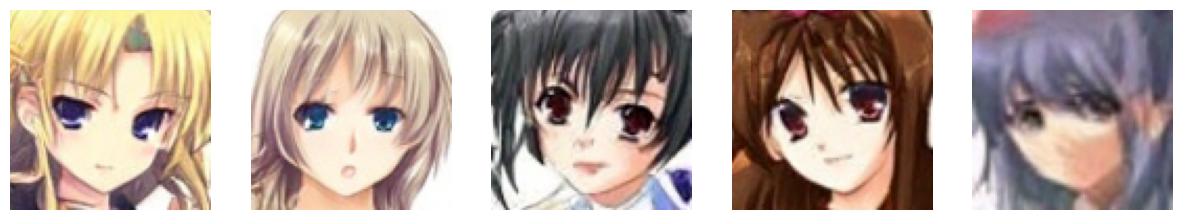

In [19]:
# --- 6. ГЕНЕРАЦІЯ (SAMPLING) ---
ema.ema_model.eval()
generated_images = sample_image(ema.ema_model, IMG_SIZE)

# Відображення результату
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    show_tensor_image(generated_images[i].cpu())
plt.show()